<center><h1>Predicting Spending on Fashion in Montréal, Québec</h1></center>

<center>Valerie Morin, March 2022</center>

<h3>Purpose</h3>

Fashion is an integral part of the local culture in Canada's second largest city of Montréal, Québec. The interest of clothing as an expression of character within this area of the world is a consequence of its quasi-European take on Canadian living and the fascinating artistic scene of this diverse city. With the power of predictive analysis, there is a straight-forward way to estimate where spending on these fashion trends is most likely to occur. This notebook will explore predictive analysis and show how different data mining models using a variety of python libraries can estimate the amount spent on clothing within each dissemination area of Montréal using a variety of descriptive variables.

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import libpysal as ps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from tabulate import tabulate
from scipy.stats import pearsonr
from pandas.api.types import is_numeric_dtype

import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import Lars
from sklearn.decomposition import PCA

<h3>Data Source and Projection</h3>

The data used to conduct this analysis was collected using the Business Analyst extension within ArcGIS Desktop. A subset of valued fields was chosen, and a shapefile of Montréal was intersected with the dissemination area data to create the base dataset Dissemination area without any households were removed. The projection of the dataset is in WGS '84 Web Mercator Auxiliary Sphere coordinate reference system. Below is an image of the resultant dataset.

Below, GeoPandas is used to create a GeoDataframe which stores the Montréal dissemination areas. The coordinate reference system is set accordingly.

In [4]:
montreal_das = gpd.read_file('montreal_das/montreal_das.shp')
montreal_das = montreal_das.to_crs(3857)

There will be multiple maps which need to be created over this report, so a function will be defined with all map elements. This will increase code efficiency.

In [5]:
def draw_map(map_title, column_name):
    
    # Map Size
    fig, ax = plt.subplots(figsize=(12, 12))

    # Scale Bar
    scale = ScaleBar(dx=1, location='lower right')
    ax.add_artist(scale)

    # North Arrow
    x, y, arrow_length = 0.05, 0.8, 0.1
    ax.annotate('N', 
                xy=(x, y), 
                xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', 
                va='center', 
                fontsize=20,
                xycoords=ax.transAxes
               )

    # Title
    ax.set_title(map_title, fontsize = 20)
    
    # Plotting the map
    montreal_das.plot(column=column_name, 
                      edgecolor="0.1",
                      linewidth=0.1,
                      cmap='OrRd', 
                      scheme='natural_breaks',
                      ax=ax,
                      
                      # Legend
                      legend=True,
                      legend_kwds={'loc': 'center left'}
                     
                     ).axis('off')

A basic choropleth map depicting the average annual houshold spending across all dissemintation areas in Montréal can be seen below. 

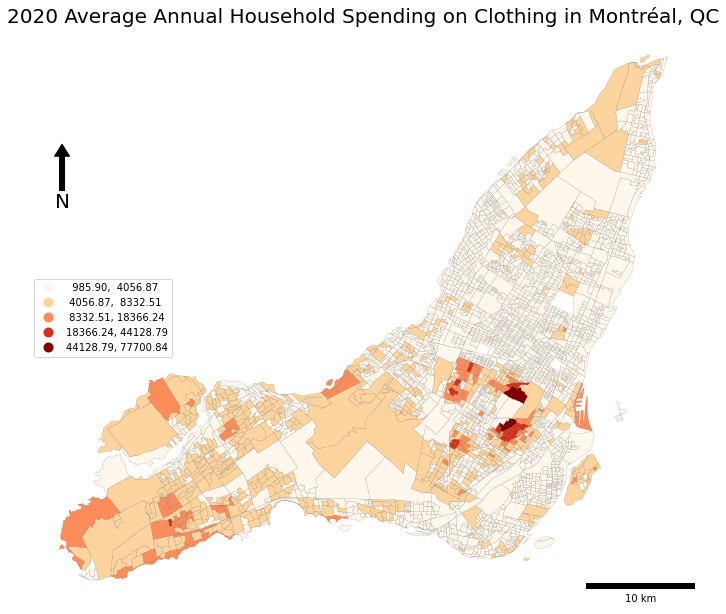

In [6]:
draw_map("2020 Average Annual Household Spending on Clothing in Montréal, QC", "HSCL001")

<h3>Data Preparation</h3>

<h5>Data Dictionary</h5>

Below is the data dictionary. Names for each field are displayed along with the relevant alias and data type of the field. The target variable (HSCL001) is seen in bold font.

In [7]:
data_dict = pd.DataFrame.from_dict({'Name':['ID', 'NAME', 'RG_NAME', 'ECYBASHHD', 'ECYPMAAVG', 'ECYPFAAVG', 'ECYHSZAVG', 'ECYMARSING', 'ECYCHAHHCH', 'ECYHRIAVG', 'ECYRELNREL', 'ECYHOMFREN', 'ECYTIMIMGT', 'ECYGEN3GEN', 'ECYWORKPOP', 'HSCC001', 'HSCL001', 'HSCS005', 'HSED002', 'HSEP005', 'HSFD991', 'HSGC003A', 'HSHC001', 'HSHF002', 'HSHO004', 'HSPC003', 'HSRE016', 'HSSH014', 'HSSH051', 'HSTR52'],
             'Alias':['ID', 'NAME', 'RG_NAME', '2020 Base Total Households', '2020 Male Average Age', '2020 Female Average Age', '2020 Private HHs Avg Num Persons', '2020 Pop Single (Never Married)', '2020 Avg Child Per Household', '2020 HH Inc: Average Cons$', '2020 Rel: No Religious Affil', '2020 HL: French', '2020 Immg: Tot Immigrants', '2020 Third Generation or More', '2020 Daytime Pop at Work', '2020 Child Care Expenditures', '2020 Clothing', '2020 Cell Phone Svcs', '2020 Education', '2020 Retirement or Pension Pay', '2020 Restaurant Meals', '2020 Casinos/Slot Machine/Lott', '2020 Health Care', '2020 HH Furnishings', '2020 Pet Food', '2020 Hair Care Prods', '2020 Photographic Goods/Svcs', '2020 Property Taxes', '2020 Hotels/Motels', '2020 Transportation By Taxi'],
             'Type':['Text', 'Text', 'Text', 'Long', 'Double', 'Double', 'Double', 'Long', 'Double', 'Double', 'Long', 'Long', 'Long', 'Long', 'Long', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double', 'Double']})

print(tabulate(data_dict, headers='keys', tablefmt='psql'))

+----+------------+----------------------------------+--------+
|    | Name       | Alias                            | Type   |
|----+------------+----------------------------------+--------|
|  0 | ID         | ID                               | Text   |
|  1 | NAME       | NAME                             | Text   |
|  2 | RG_NAME    | RG_NAME                          | Text   |
|  3 | ECYBASHHD  | 2020 Base Total Households       | Long   |
|  4 | ECYPMAAVG  | 2020 Male Average Age            | Double |
|  5 | ECYPFAAVG  | 2020 Female Average Age          | Double |
|  6 | ECYHSZAVG  | 2020 Private HHs Avg Num Persons | Double |
|  7 | ECYMARSING | 2020 Pop Single (Never Married)  | Long   |
|  8 | ECYCHAHHCH | 2020 Avg Child Per Household     | Double |
|  9 | ECYHRIAVG  | 2020 HH Inc: Average Cons$       | Double |
| 10 | ECYRELNREL | 2020 Rel: No Religious Affil     | Long   |
| 11 | ECYHOMFREN | 2020 HL: French                  | Long   |
| 12 | ECYTIMIMGT | 2020 Immg: Tot Immig

<h5>Data Quality</h5>

Here is where I show the quality of the data (missing values included)

In [8]:
print("\nZero Values:\n")
for column_name, column in montreal_das.transpose().iterrows():
    if montreal_das[(montreal_das[column_name] == 0)].shape[0]:
        print("%-25s\t\t%2d" % (data_dict.loc[data_dict['Name'] == column_name, 'Alias'].iloc[0], len(montreal_das[montreal_das[column_name] == 0])))
        
print("\nMissing Values:\n")
for column_name, column in montreal_das.transpose().iterrows():
    if montreal_das[(montreal_das[column_name] == '')].shape[0]:
        print("%-25s\t\t%2d" % (data_dict.loc[data_dict['Name'] == column_name, 'Alias'].iloc[0], len(montreal_das[montreal_das[column_name] == 0])))


Zero Values:

2020 Pop Single (Never Married)		 1
2020 Avg Child Per Household		10
2020 Rel: No Religious Affil		63
2020 HL: French          		 4
2020 Immg: Tot Immigrants		 1
2020 Third Generation or More		18
2020 Daytime Pop at Work 		85

Missing Values:



There are no missing values within the dataset and there are some zero values, but these are all understandable cases. For instance, in a small dissemination area, there may be one area where 

<h3>Predicting a Numeric (Continuous) Target Variable</h3>

<h5>Correlation Between Target Variable and Predictors</h5>

Here is where I show the correlation

In [9]:
print("\nPearson's Correlation Between Average Annual Clothing Household Expense and Top Predictors\n")

top_corrs = {}

for column_name, column in montreal_das.transpose().iterrows():
    if is_numeric_dtype(montreal_das[column_name]):
        corr = montreal_das[column_name].corr(montreal_das['HSCL001'])
        if (corr > 0.8 and corr < 1) or (corr < -0.8 and corr > -1):
            top_corrs[column_name] = corr
            
for w in sorted(top_corrs, key=top_corrs.get, reverse=True):
    print("%6.2f - %s" % (top_corrs[w], data_dict.loc[data_dict['Name'] == w, 'Alias'].iloc[0]))


Pearson's Correlation Between Average Annual Clothing Household Expense and Top Predictors

  0.99 - 2020 HH Inc: Average Cons$
  0.97 - 2020 Health Care
  0.97 - 2020 Hotels/Motels
  0.96 - 2020 HH Furnishings
  0.95 - 2020 Education
  0.95 - 2020 Restaurant Meals
  0.95 - 2020 Property Taxes
  0.94 - 2020 Cell Phone Svcs
  0.90 - 2020 Pet Food
  0.88 - 2020 Hair Care Prods
  0.87 - 2020 Child Care Expenditures
  0.87 - 2020 Photographic Goods/Svcs


<h5>Neural Network</h5>

Begin by splitting the target variable from the predictors and normalizing between 0 and 1.

In [10]:
model_performance = {}

target_variable = ['HSCL001']
predictors = ['ECYHRIAVG', 'HSHC001', 'HSSH051', 'HSHF002', 'HSED002', 'HSFD991', 'HSSH014', 'HSCS005', 'HSHO004', 'HSPC003', 'HSCC001', 'HSRE016']

montreal_das[target_variable] = montreal_das[target_variable]/montreal_das[target_variable].max()
montreal_das[predictors] = montreal_das[predictors]/montreal_das[predictors].max()

montreal_das[predictors].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
ECYHRIAVG,3197.0,0.043193,0.038172,1.199281e-02,0.028577,0.034319,0.045991,1.0
HSHC001,3197.0,0.055749,0.038615,1.482462e-02,0.038454,0.045918,0.061645,1.0
HSSH051,3197.0,0.025893,0.043297,2.436418e-03,0.007532,0.015782,0.026672,1.0
HSHF002,3197.0,0.037682,0.041151,8.546807e-03,0.024404,0.029105,0.036015,1.0
HSED002,3197.0,0.029185,0.045834,2.041188e-03,0.012975,0.016555,0.028026,1.0
HSFD991,3197.0,0.055626,0.039661,1.213154e-02,0.038579,0.046638,0.060581,1.0
HSSH014,3197.0,0.026705,0.043069,8.362999e-07,0.007061,0.013407,0.031079,1.0
HSCS005,3197.0,0.101487,0.041934,3.802528e-02,0.080016,0.089381,0.114443,1.0
HSHO004,3197.0,0.041574,0.039937,2.176387e-03,0.022236,0.030812,0.045471,1.0
HSPC003,3197.0,0.083773,0.038906,2.199913e-02,0.066815,0.077602,0.092105,1.0


Now create the training and test datasets.

In [11]:
x = montreal_das[predictors].values
y = montreal_das[target_variable].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2237, 12)
(960, 12)
(2237, 1)
(960, 1)


Create a function that will run models and return R2 values to measure performance.

In [12]:
def get_r2(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train.ravel())
    return model.score(x_test, y_test)

Now test eight regression models and determine the one with the highest accuracy.

In [13]:
model_performance["Neural Network"] = get_r2(MLPRegressor(hidden_layer_sizes=(12, 12, 12), activation='relu', solver='adam', max_iter=500), x_train, x_test, y_train, y_test)
model_performance["Ordinary Least Squares"] = get_r2(LinearRegression(), x_train, x_test, y_train, y_test)
model_performance["Stochastic Gradient Descent"] = get_r2(SGDRegressor(), x_train, x_test, y_train, y_test)
model_performance["K-Nearest Neighbors"] = get_r2(KNeighborsRegressor(n_neighbors=2), x_train, x_test, y_train, y_test)
model_performance["Gaussian Process"] = get_r2(GaussianProcessRegressor(), x_train, x_test, y_train, y_test)
model_performance["Decision Tree"] = get_r2(DecisionTreeRegressor(), x_train, x_test, y_train, y_test)
model_performance["Support Vector Machine"] = get_r2(LinearSVR(random_state=0, tol=1e-05, max_iter=100000), x_train, x_test, y_train, y_test)
model_performance["Random Forest"] = get_r2(RandomForestRegressor(max_depth=2, random_state=0), x_train, x_test, y_train, y_test)

for model in sorted(model_performance, key=model_performance.get, reverse=True):
    print("%30s - %.3f" % (model, model_performance[model]))

           K-Nearest Neighbors - 0.986
                 Decision Tree - 0.981
        Ordinary Least Squares - 0.980
        Support Vector Machine - 0.974
                Neural Network - 0.922
              Gaussian Process - 0.871
                 Random Forest - 0.851
   Stochastic Gradient Descent - 0.510


K-Nearest Neighbors Regressor with 2 neighbors seems to be the winner amongst the models. We should map the residuals of this model.

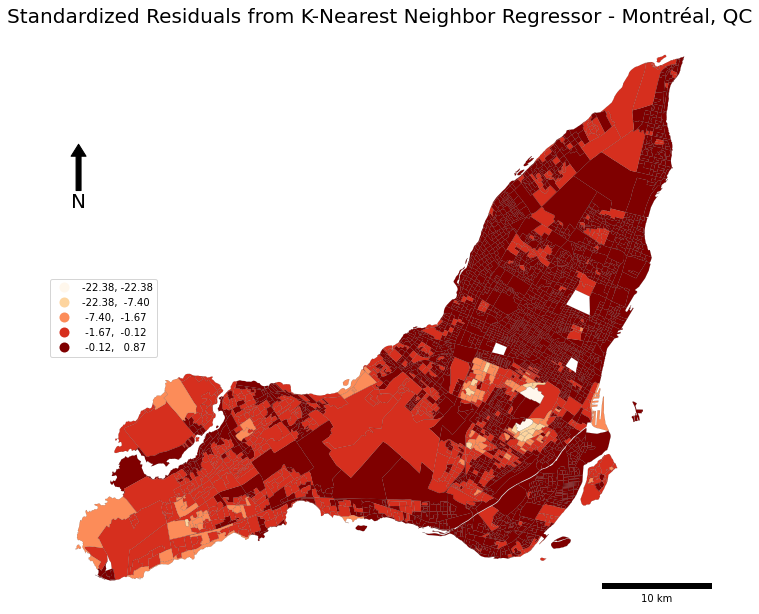

In [345]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_train, y_train.ravel())

prediction = knn.predict(x)
residual = (y - prediction)

montreal_das['residuals'] = sum(residual)
montreal_das['std_residuals'] = (montreal_das["residuals"] - montreal_das['residuals'].mean()) / montreal_das['residuals'].std()

draw_map("Standardized Residuals from K-Nearest Neighbor Regressor - Montréal, QC", 'std_residuals')

<h3>Principal Component Analysis (PCA)</h3>

To reduce linear dimensionality of the data to a lower dimensional space, we can use the PCA method provided by sklearn.

In [17]:
pca = PCA(n_components=2)

pca.fit(x)
print(pca.explained_variance_ratio_)

[0.9012015  0.02919725]


I produced my own table showing the covariance between different fields in the dataframe.

In [15]:
print("%8s|%8s|%8s|%8s|%8s|%8s|%8s|%8s|%8s|%8s|%8s|%8s|" % ('ECYHRIAVG', 'HSHC001', 'HSSH051', 'HSHF002', 'HSED002', 'HSFD991', 'HSSH014', 'HSCS005', 'HSHO004', 'HSPC003', 'HSCC001', 'HSRE016'))
for row in pca.get_covariance():
    print()
    row_str = ""
    for col in row:
        row_str += "%8.6f|" % col
    print(row_str)

ECYHRIAVG| HSHC001| HSSH051| HSHF002| HSED002| HSFD991| HSSH014| HSCS005| HSHO004| HSPC003| HSCC001| HSRE016|

0.001566|0.001410|0.001604|0.001488|0.001649|0.001456|0.001554|0.001498|0.001419|0.001317|0.001321|0.001412|

0.001410|0.001546|0.001586|0.001454|0.001616|0.001439|0.001550|0.001489|0.001428|0.001289|0.001259|0.001420|

0.001604|0.001586|0.001945|0.001675|0.001855|0.001638|0.001748|0.001686|0.001596|0.001481|0.001487|0.001588|

0.001488|0.001454|0.001675|0.001732|0.001751|0.001524|0.001599|0.001552|0.001435|0.001401|0.001472|0.001430|

0.001649|0.001616|0.001855|0.001751|0.002072|0.001687|0.001779|0.001723|0.001605|0.001544|0.001602|0.001598|

0.001456|0.001439|0.001638|0.001524|0.001687|0.001628|0.001585|0.001529|0.001445|0.001347|0.001357|0.001438|

0.001554|0.001550|0.001748|0.001599|0.001779|0.001585|0.001850|0.001642|0.001576|0.001419|0.001381|0.001568|

0.001498|0.001489|0.001686|0.001552|0.001723|0.001529|0.001642|0.001720|0.001507|0.001375|0.001357|0.001500|

0.001419|